In [37]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx

from pykeen.triples import TriplesFactory

import matplotlib.pyplot as plt

from db.graph import Neo4JConnector

In [2]:
random_state = 4201312

neo4j = Neo4JConnector.create_from_config("../config.ini")

In [99]:
g = nx.DiGraph()
query = """CALL {
        MATCH (p:Player)-[pi:PLAYS_IN]->(pim:PlayerInMatch)
        WITH p, COUNT(pim.matchID) AS matchesPlayed 
        WHERE matchesPlayed > 10
        RETURN p
        LIMIT 5
    }
    MATCH (p)-[pc:PLAYS_CHAMP]->(c:Champion), (p)-[hp:HAS_POSITION]->(pos:Position)
    RETURN *"""

neo4j.create_graph_from_query(graph=g, query=query)
str(g)

'DiGraph with 23 nodes and 22 edges'

In [100]:
triplets = np.array([[g.nodes[x[0]]["properties"]["summonerName"],
  g.edges[x]["type"],
  g.nodes[x[1]]["properties"]["championID" if g.edges[x]["type"] == "PLAYS_CHAMP" else "positionID"]]
  for x in g.edges])

triplets

array([['뭘해도안될사나이', 'HAS_POSITION', 'BOT'],
       ['뭘해도안될사나이', 'PLAYS_CHAMP', 'Xayah'],
       ['뭘해도안될사나이', 'PLAYS_CHAMP', 'Caitlyn'],
       ['뭘해도안될사나이', 'PLAYS_CHAMP', 'LeeSin'],
       ['뭘해도안될사나이', 'PLAYS_CHAMP', 'Ezreal'],
       ['뭘해도안될사나이', 'PLAYS_CHAMP', 'MissFortune'],
       ['LeanGreco', 'HAS_POSITION', 'SUP'],
       ['LeanGreco', 'PLAYS_CHAMP', 'Zilean'],
       ['LeanGreco', 'HAS_POSITION', 'MID'],
       ['뭬테오', 'HAS_POSITION', 'MID'],
       ['뭬테오', 'PLAYS_CHAMP', 'Irelia'],
       ['뭬테오', 'PLAYS_CHAMP', 'Aatrox'],
       ['뭬테오', 'PLAYS_CHAMP', 'LeeSin'],
       ['뭬테오', 'PLAYS_CHAMP', 'Yasuo'],
       ['뭬테오', 'PLAYS_CHAMP', 'Lucian'],
       ['뭬테오', 'HAS_POSITION', 'SUP'],
       ['I Love blade', 'HAS_POSITION', 'TOP'],
       ['I Love blade', 'PLAYS_CHAMP', 'Mordekaiser'],
       ['I Love blade', 'PLAYS_CHAMP', 'Nocturne'],
       ['I Love blade', 'PLAYS_CHAMP', 'Sett'],
       ['I Love blade', 'PLAYS_CHAMP', 'Ornn'],
       ['I Love blade', 'PLAYS_CHAMP', 'Darius']], 

In [101]:
tf_full = TriplesFactory.from_labeled_triples(triplets)
training, testing, validation = tf_full.split([.8, .1, .1], random_state=random_state)

ValueError: Could not find a coverage of all entities and relation with only 17 triples.

In [107]:
from pykeen.pipeline import pipeline

result = pipeline(
    model='RotatE',
    loss="softplus",
    training=training,
    testing=testing,
    validation=validation,
    model_kwargs=dict(embedding_dim=3, random_seed=42),  # Increase the embedding dimension
    optimizer_kwargs=dict(lr=0.1),  # Adjust the learning rate
    training_kwargs=dict(num_epochs=50, use_tqdm_batch=False),  # Increase the number of epochs
    device="cuda"
)

INFO:pykeen.pipeline.api:Using device: cuda


Training epochs on cuda:0:   0%|          | 0/50 [00:00<?, ?epoch/s]

Evaluating on cuda:0:   0%|          | 0.00/3.91k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.23s seconds


<Axes: title={'center': 'Losses Plot'}, xlabel='Epoch', ylabel='softplus Loss'>

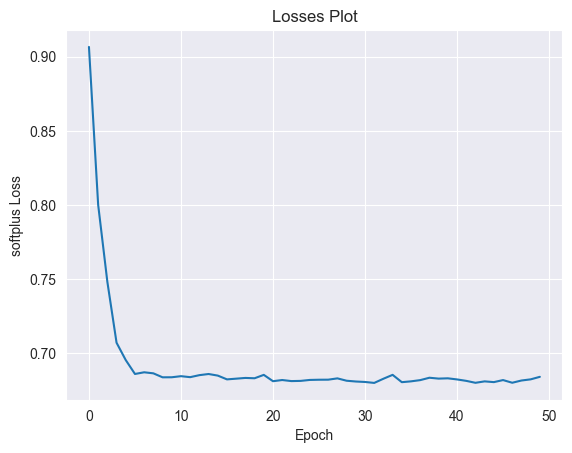

In [108]:
model = result.model

#plot loss
result.plot_losses()

In [109]:
from pykeen.evaluation import RankBasedEvaluator
# The result object also contains the evaluation metrics result.metric_results.to_df()

# Create an evaluator
evaluator = RankBasedEvaluator()

# Evaluate the model
metrics = evaluator.evaluate(result.model, testing.mapped_triples, additional_filter_triples=[training.mapped_triples, validation.mapped_triples])

# Print the metrics
print(f"Hits@1: {metrics.get_metric('hits@1')}")
print(f"Hits@3: {metrics.get_metric('hits@3')}")
print(f"Hits@5: {metrics.get_metric('hits@5')}")
print(f"Hits@10: {metrics.get_metric('hits@10')}")
print(f"Mean Reciprocal Rank: {metrics.get_metric('mean_reciprocal_rank')}")

Evaluating on cuda:0:   0%|          | 0.00/3.91k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.16s seconds


Hits@1: 0.018807574206755374
Hits@3: 0.05974923234390993
Hits@5: 0.09327021494370522
Hits@10: 0.16542988741044012
Mean Reciprocal Rank: 0.06600545346736908


In [110]:
id_to_entity={v: k for k, v in training.entity_to_id.items()}
id_to_relation={v: k for k, v in training.relation_to_id.items()}

In [111]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

plt.figure(figsize=(6, 6))
pca = PCA(n_components=2)
entity_embeddings = model.entity_representations[0](indices=None).cpu().detach().numpy()
m = pca.fit(entity_embeddings)

eu = m.transform(entity_embeddings)
# plt.plot(eu[:, 0], eu[:, 1],'.b')
for i, entity in enumerate(tf_full.entity_id_to_label):
    plt.annotate(
        text=id_to_entity[entity],
        xy=(eu[i, 0], eu[i, 1]),
        color="tab:blue",
        ha="center", va="center"
    )

    
relation_embeddings = model.relation_representations[0](indices=None).cpu().detach().numpy()
ru = pca.transform(relation_embeddings)
for i, relation in enumerate(tf_full.relation_id_to_label):
    plt.annotate(
        text=id_to_relation[relation],
        xy=(0,0), xytext=(ru[i, 0], ru[i, 1]),
        arrowprops=dict(
            arrowstyle="<-",
            color="tab:red",
            shrinkA=5,
            shrinkB=5,
            patchA=None,
            patchB=None,
            connectionstyle="arc3,rad=0."
        )
    )

plt.xlim([-2, 2])
plt.ylim([-1, 1])

ValueError: Complex data not supported
[[ 1.9122461 +2.320268j   -0.10854317+0.21762533j -0.78925335-0.64469343j]
 [ 1.7497166 +2.0427687j  -0.05955952+0.49008903j -1.0202916 -0.1845856j ]
 [ 2.3202546 +2.0388029j   0.17995402+0.3097526j  -0.5938022 -0.67018294j]
 ...
 [ 1.5346836 +2.072058j   -0.3882595 -0.1178201j  -0.7757228 -0.53811306j]
 [ 1.8287237 +2.3732054j  -0.00656068+0.10800394j -0.47666734-0.41234207j]
 [ 1.5997305 +1.9809577j  -0.9652589 +0.13568759j -1.7578248 -1.4886686j ]]


<Figure size 600x600 with 0 Axes>

In [85]:
from pykeen.predict import predict_triples

pack = predict_triples(model=result.model.cuda(), triples=validation)
predictions = pack.process(factory=validation).df
predictions

,head_id,head_label,relation_id,relation_label,tail_id,tail_label,score
0,1055,Jesus Dogs,0,HAS_POSITION,1703,SUP,-6.944811
1,1873,Talez,1,PLAYS_CHAMP,1252,Lucian,-8.027916
2,6073,챌린저카타장인,1,PLAYS_CHAMP,1107,Kaisa,-8.939999
3,3344,국대탑정광문,1,PLAYS_CHAMP,619,Darius,-8.504278
4,6098,청주 김병만,1,PLAYS_CHAMP,1874,Taliyah,-8.844671
...,...,...,...,...,...,...,...
3903,2659,mbxn,1,PLAYS_CHAMP,2068,Yasuo,-7.473509
3904,403,Baby gong,1,PLAYS_CHAMP,1068,Jinx,-9.787330
3905,2982,wnwn,1,PLAYS_CHAMP,2042,Xayah,-8.860605
3906,489,Ceno,1,PLAYS_CHAMP,842,Garen,-10.033367


In [82]:
predictions.groupby(by=["head_id", "head_label"]).agg({"score": ["mean", "std", "count"]})

score                
                           mean       std count
head_id head_label                             
6           zhony     -8.549776       NaN     1
11        코가 토모에      -7.074272       NaN     1
13       02년생 프로지망    -8.504862  0.637751     2
18       JUGKING six  -8.526512  0.583304     2
19       MeguMeguFire -8.315632       NaN     1
...                         ...       ...   ...
6695    흔한닝겐          -9.755445       NaN     1
6696    흙흘흙흙흙         -8.960005       NaN     1
6699    흥커복           -7.841328  0.566914     2
6703    히키 승수         -9.509515       NaN     1
6708    힙합힙합          -9.463398       NaN     1

[3036 rows x 3 columns]